## Experiments for binary treatment effect estimation comparison

In [ ]:
import sys, os

# add the project root to sys.path
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')

import CausalEGM as cegm
# import the module
from models import *

import numpy as np
import pickle
import os
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(42)

## Example of hyperparameter tuning

In [ ]:
from functools import lru_cache

def tune_and_eval(model_name,
                  X_train, t_train, y_train,
                  X_val,   t_val,   y_val,
                  X_test,  t_test,  y_test,
                  provided_params=None,
                  n_trials=10):
    """
    If best_params is None: runs Optuna, returns (ITE_array, best_params).
    If best_params is given: skips Optuna, returns ITE_array only.
    """
    # 1) hyperparam search
    if provided_params is None:
        import optuna
        study = optuna.create_study(direction="minimize",
                                    study_name=f"{model_name}_tune")
        def objective(trial):
            # common
            lr     = trial.suggest_loguniform("lr", 1e-5, 1e-2)
            wd     = trial.suggest_loguniform("wd", 1e-5, 1e-2)
            bs     = trial.suggest_categorical("bs", [32, 128, 256])
            epochs = trial.suggest_int("epochs", 200, 600)

            # model‐specific
            if model_name == "tarnet":
                rep1 = trial.suggest_int("rep1", 20, 50 )
                rep2 = trial.suggest_int("rep2", 50, 100)
                head = trial.suggest_int("head", 50, 100)
                drop = trial.suggest_uniform("drop", 0.0, 0.001)
                trainer = TARNetTrainer(X_train.shape[1], [rep1,rep2], [head], drop)

            elif model_name == "cfrnet":
                rep1   = trial.suggest_int("rep1", 50, 200)
                rep2   = trial.suggest_int("rep2", 50, 200)
                head   = trial.suggest_int("head", 50, 200)
                drop   = trial.suggest_uniform("drop", 0.0, 0.001)
                ipm_w  = trial.suggest_loguniform("ipm_weight", 0.01, 10.0)
                trainer = CFRNetTrainer(X_train.shape[1], [rep1,rep2], [head], drop, ipm_w)

            elif model_name == "cevae":
                ld = trial.suggest_int("latent_dim", 10, 200)
                hd = trial.suggest_int("hidden_dim", 20, 400)
                nl = trial.suggest_int("num_layers", 2, 5)     # note: 2→5 to avoid pop error
                ns = trial.suggest_categorical("num_samples", [10,50,100,200])
                trainer = CEVAETrainer(X_train.shape[1], ld, hd, nl, ns)

            else:  # dragonnet
                sh = trial.suggest_int("shared_hidden", 50, 200)
                oh = trial.suggest_int("outcome_hidden", 50, 200)
                trainer = DragonNetTrainer(X_train.shape[1], sh, oh)

            return trainer.fit(
                X_train, t_train, y_train,
                X_val,   t_val,   y_val,
                lr=lr, weight_decay=wd,
                batch_size=bs, epochs=epochs
            )

        study.optimize(objective, n_trials=n_trials)
        best_params = study.best_params
        print(f"🔍 Best params for {model_name}: {best_params}")
    else:
        best_params = provided_params
    # 2) retrain on combined train+val
    X_trn = np.vstack([X_train, X_val])
    t_trn = np.concatenate([t_train, t_val])
    y_trn = np.concatenate([y_train, y_val])

    if model_name == "tarnet":
        trainer = TARNetTrainer(
            X_trn.shape[1],
            [best_params['rep1'], best_params['rep2']],
            [best_params['head']],
            best_params['drop']
        )
    elif model_name == "cfrnet":
        trainer = CFRNetTrainer(
            X_trn.shape[1],
            [best_params['rep1'], best_params['rep2']],
            [best_params['head']],
            best_params['drop'],
            best_params['ipm_weight']
        )
    elif model_name == "cevae":
        trainer = CEVAETrainer(
            X_trn.shape[1],
            best_params['latent_dim'],
            best_params['hidden_dim'],
            best_params['num_layers'],
            best_params['num_samples']
        )
    else:
        trainer = DragonNetTrainer(
            X_trn.shape[1],
            best_params['shared_hidden'],
            best_params['outcome_hidden']
        )

    trainer.fit(
        X_trn, t_trn, y_trn,
        X_test, t_test, y_test,
        lr=best_params['lr'],
        weight_decay=best_params['wd'],
        batch_size=best_params['bs'],
        epochs=best_params['epochs']
    )

    if model_name == "cevae":
        ite = trainer.predict(X_test)
    else:
        y0p, y1p = trainer.predict(X_test)
        ite = y1p - y0p

    return (ite, best_params) if provided_params is None else ite


## Fitting synthetic data generated by causl

### Data generation

In [ ]:
nrep = 30  # Number of repetitions
n_tr = 5000  # Training sample size
n_val = 400
n_te = 400  # Testing sample size
strength_instr_values = np.arange(0,2.5,0.5)  # Varying strength of instrumental variables
nI = 5 # Fixed number of instrumental variables
nX = 5
nO = 0
nS = 0
binary_intervention = True
num_iters = 1000 # Fixed number of training iterations
ate = 2
strength_conf = 1
strength_outcome = 0

# Initialize tracker for strength_instr
tracker = {strength_instr: {"fr": [], "dr": [], "causalegm":[], "tarnet":[], "cfrnet":[], "cevae":[], "dragonnet":[]}
           for strength_instr in strength_instr_values}
# tracker = {strength_instr: {"fr": [], "dr": [], "causalegm":[], "dragonnet":[]}
#     for strength_instr in strength_instr_values}

best_hps = {model: None for model in ["tarnet","cfrnet","cevae","dragonnet"]}
# best_hps = {model: None for model in ["dragonnet"]}
# Begin loop over strength_instr
for strength_instr in strength_instr_values:
    print(f"Running experiments for strength_instr = {strength_instr}")
    p = nI + nX + nO + nS  # Update the number of covariates
    
    for rep in tqdm(range(nrep)):
        # Generate training and testing data
        df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
            torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
        y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)
        
        z_tr_np = df_tr[[f"X{i}" for i in range(1, p + 1)]].values
        x_tr_np = df_tr['A'].values
        y_tr_np = df_tr['y'].values

        df_val = generate_data_causl(n=n_val, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)


        z_val_np = df_val[[f"X{i}" for i in range(1, p + 1)]].values
        x_val_np = df_val['A'].values
        y_val_np = df_val['y'].values

        df_te = generate_data_causl(n=n_te, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)

        z_te_np = df_te[[f"X{i}" for i in range(1, p + 1)]].values
        x_te_np = df_te['A'].values
        y_te_np = df_te['y'].values
        z_te = torch.tensor(z_te_np, dtype=torch.float32)

        model = Frengression(x_dim = x_tr.shape[1], y_dim = 1, z_dim =z_tr.shape[1], 
                             noise_dim=1, num_layer=3, hidden_dim=100, 
                             device=device, x_binary=binary_intervention, z_binary_dims=0)

        # Train Frengression model
        model.train_y(x=x_tr,
                      z=z_tr, 
                      y=y_tr, 
                      num_iters=num_iters, lr=1e-4, print_every_iter=500, tol=0)

        # Sample model distributions
        P0 = model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_te).numpy().reshape(-1, 1)
        P1 = model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_te).numpy().reshape(-1, 1)
        ate_fr = np.mean(P1) - np.mean(P0)
        print(ate_fr)

        # DR Estimation
        ate_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np ,x_te_np, y_te_np, z_te_np)

        # for model in ["tarnet","cfrnet","cevae","dragonnet"]:
        for model in ["dragonnet"]:
            if rep == 0:
                ite, best_hps[model] = tune_and_eval(
                    model,
                    z_tr_np, x_tr_np, y_tr_np,
                    z_val_np, x_val_np, y_val_np,
                    z_te_np, x_te_np,y_te_np,
                    provided_params=None,
                    n_trials=30
                )
            else:
                ite = tune_and_eval(
                    model,
                    z_tr_np, x_tr_np, y_tr_np,
                    z_val_np, x_val_np, y_val_np,
                    z_te_np, x_te_np,y_te_np,
                    provided_params=best_hps[model]
                )
            tracker[strength_instr][model].append(ite.mean())


        cegm_params = {'dataset': 'Semi_acic', 
                        'output_dir': '.', 
                        'v_dim': z_tr.shape[1], 
                        'z_dims': [1, 1, 1, 1], 
                        'lr': 0.0002, 
                        'alpha': 1, 
                        'beta': 1, 
                        'gamma': 10, 
                        'g_d_freq': 5, 
                        'g_units': [64, 64, 64, 64, 64], 
                        'e_units': [64, 64, 64, 64, 64], 
                        'f_units': [64, 32, 8], 
                        'h_units': [64, 32, 8], 
                        'dz_units': [64, 32, 8], 
                        'dv_units': [64, 32, 8], 'save_res': False, 'save_model': False, 'binary_treatment': True, 'use_z_rec': True, 'use_v_gan': True}
        egm_model = cegm.CausalEGM(params=cegm_params, random_seed=42)
        egm_model.train(data=[x_tr,y_tr,z_tr],n_iter=1000, verbose=False)
        ate_causalegm=egm_model.getCATE(z_te).mean()

        # Log results
        tracker[strength_instr]["fr"].append(ate_fr)
        tracker[strength_instr]["dr"].append(ate_dr)
        tracker[strength_instr]["causalegm"].append(ate_causalegm)
    
        

In [41]:
import json
output_dir = "result/binary/"
os.makedirs(output_dir, exist_ok=True)
tracker_serializable = {
    str(k): [float(x) for x in v_dict.get("fr",[])] 
              + []  # (we'll overwrite below) 
    for k, v_dict in tracker.items()
}
# actually build full dict:
tracker_serializable = {
    str(k): {
        model: [float(x) for x in v_list]
        for model, v_list in v_dict.items()
    }
    for k, v_dict in tracker.items()
}

# 3) write it out
with open(os.path.join(output_dir, "synthetic_1k_v2.json"), "w") as f:
    json.dump(tracker_serializable, f, indent=4)


In [ ]:
import json
with open("result/binary/synthetic_1k_v2.json") as f:
    tracker = json.load(f)

In [46]:
import json
import numpy as np
import pandas as pd

# 1) Load your tracker
with open("result/binary/synthetic_1k_v2.json") as f:
    tracker = json.load(f)

# 2) Define strengths and methods in the order you want
strengths = sorted(tracker.keys(), key=lambda x: float(x))
methods   = ["fr","dr","causalegm","dragonnet"]

# 3) Build a MultiIndex DataFrame
rows = []
index = []
for s in strengths:
    ests = tracker[s]
    # precompute each method’s metrics
    stats = {}
    for m in methods:
        arr = np.array(ests[m])
        stats[m] = {
            "rmse": np.sqrt(((arr - 2.0)**2).mean()),
            "bias": arr.mean() - 2.0,
            "mae":  np.abs(arr - 2.0).mean()
        }
    # for each metric, make one row
    for metric in ["rmse","bias","mae"]:
        index.append((s, metric))
        rows.append([stats[m][metric] for m in methods])

df = pd.DataFrame(rows,
                  index=pd.MultiIndex.from_tuples(index,
                                                  names=["strength","metric"]),
                  columns=methods)

# 4) Formatting function
def fmt(x):
    if 1e-2 <= abs(x) < 1e0:
        return f"{x:.3f}"
    else:
        return f"{x:.3e}"

df_fmt = df.applymap(fmt)

# 5) Print LaTeX
print(df_fmt.to_latex(multicolumn=True, multirow=True, escape=False))


\begin{tabular}{llllll}
\toprule
 &  & fr & dr & causalegm & dragonnet \\
strength & metric &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{0.0} & rmse & 0.056 & 0.290 & 0.151 & 0.070 \\
 & bias & -3.941e-03 & 0.225 & -0.117 & 0.031 \\
 & mae & 0.048 & 0.253 & 0.130 & 0.056 \\
\cline{1-6}
\multirow[t]{3}{*}{0.5} & rmse & 0.076 & 0.290 & 0.149 & 0.114 \\
 & bias & -0.019 & 0.258 & -0.124 & 0.042 \\
 & mae & 0.059 & 0.258 & 0.132 & 0.100 \\
\cline{1-6}
\multirow[t]{3}{*}{1.0} & rmse & 0.071 & 0.849 & 0.193 & 0.055 \\
 & bias & -0.015 & 0.480 & -0.173 & 0.015 \\
 & mae & 0.056 & 0.480 & 0.173 & 0.039 \\
\cline{1-6}
\multirow[t]{3}{*}{1.5} & rmse & 0.086 & 0.690 & 0.262 & 0.155 \\
 & bias & -0.028 & 0.530 & -0.245 & 0.080 \\
 & mae & 0.069 & 0.543 & 0.245 & 0.117 \\
\cline{1-6}
\multirow[t]{3}{*}{2.0} & rmse & 0.084 & 0.524 & 0.287 & 0.113 \\
 & bias & -0.026 & 0.437 & -0.274 & 0.028 \\
 & mae & 0.071 & 0.466 & 0.274 & 0.095 \\
\cline{1-6}
\bottomrule
\end{tabular}



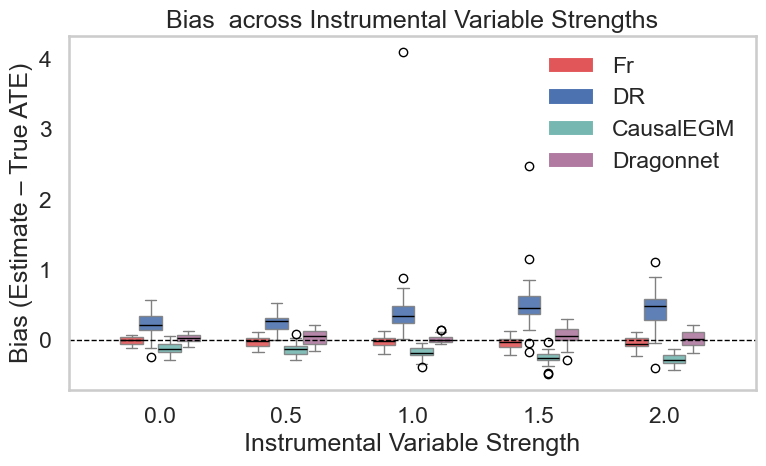

In [68]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load results
with open("result/binary/synthetic_1k_v2.json") as f:
    tracker = json.load(f)

# Sort strengths and define methods + swapped pastel colors + display names
strengths = sorted(tracker.keys(), key=lambda x: float(x))
methods   = ["fr", "dr", "causalegm", "dragonnet"]
display_names = {"fr": "Fr", "dr": "DR", "causalegm": "CausalEGM", "dragonnet": "Dragonnet"}
colors    = {
    "fr":        "#E15759",  # now DR’s old pastel red
    "dr":        "#4C72B0",  # now FR’s old pastel blue
    "causalegm": "#76B7B2",  # pastel teal
    "dragonnet": "#B07AA1",  # pastel purple
}

fig, ax = plt.subplots(figsize=(8, 5))
n = len(strengths)
m = len(methods)
total_width = .6
box_width = total_width / m * 1.2

# Plot bias boxplots
for i, s in enumerate(strengths):
    for j, meth in enumerate(methods):
        offset = (j - (m - 1) / 2) * (total_width / m)
        pos = i + offset
        bias = np.array(tracker[s][meth]) - 2.0
        ax.boxplot(
            bias,
            positions=[pos],
            widths=box_width,
            patch_artist=True,
            boxprops=dict(facecolor=colors[meth], alpha=0.9, edgecolor='gray'),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'),
            medianprops=dict(color='black', linewidth=1)
        )

# Zero‐bias line (no legend entry)
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Clean up axes
ax.set_xticks(range(n))
ax.set_xticklabels(strengths)
ax.set_xlabel("Instrumental Variable Strength")
ax.set_ylabel("Bias (Estimate – True ATE)")
ax.grid(False)
ax.set_facecolor('white')

# Legend: only the four methods
handles = [Patch(facecolor=colors[m], label=display_names[m]) for m in methods]
ax.legend(handles=handles, loc="upper right", frameon=False)

ax.set_title("Bias  across Instrumental Variable Strengths")
plt.tight_layout()
plt.show()


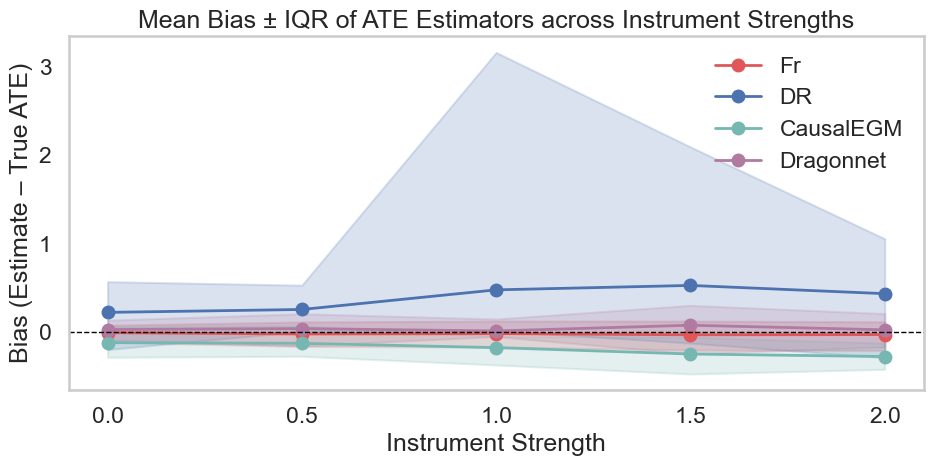

In [69]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load results
with open("result/binary/synthetic_1k_v2.json") as f:
    tracker = json.load(f)

# Sort strengths and define methods + updated colors + display names
strengths = sorted(tracker.keys(), key=lambda x: float(x))
methods   = ["fr", "dr", "causalegm", "dragonnet"]
display_names = {"fr": "Fr", "dr": "DR", "causalegm": "CausalEGM", "dragonnet": "Dragonnet"}
colors    = {
    "fr":        "#E15759",  # swapped pastel red
    "dr":        "#4C72B0",  # swapped pastel blue
    "causalegm": "#76B7B2",  # pastel teal
    "dragonnet": "#B07AA1",  # pastel purple (new)
}

# Prepare figure
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(strengths))

# Plot each method's mean ± IQR
for meth in methods:
    all_bias = [np.array(tracker[s][meth]) - 2.0 for s in strengths]
    means = np.array([b.mean() for b in all_bias])
    q1    = np.array([np.percentile(b, 1) for b in all_bias])
    q3    = np.array([np.percentile(b, 99) for b in all_bias])
    
    ax.plot(x, means, label=display_names[meth],
            color=colors[meth], marker='o', linewidth=2)
    ax.fill_between(x, q1, q3, color=colors[meth], alpha=0.2)

# Zero bias line
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Axes & labels
ax.set_xticks(x)
ax.set_xticklabels(strengths)
ax.set_xlabel("Instrument Strength")
ax.set_ylabel("Bias (Estimate – True ATE)")
ax.set_facecolor('white')
ax.grid(False)

# Legend only the methods
ax.legend(loc="upper right", frameon=False)

ax.set_title("Mean Bias ± IQR of ATE Estimators across Instrument Strengths")
plt.tight_layout()
plt.show()
